# Importing libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
pd.set_option("display.max_columns", 100)

from datetime import datetime

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


# for Q-Q plots
import scipy.stats as stats
from sklearn.base import clone
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Reading the data

In [2]:
data=pd.read_csv('train.csv')


In [3]:
data.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01-12-17,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01-12-17,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01-12-17,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01-12-17,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01-12-17,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         5760 non-null   int64  
 1   Date                       5760 non-null   object 
 2   y                          5760 non-null   int64  
 3   Hour                       5760 non-null   int64  
 4   Temperature(�C)            5760 non-null   float64
 5   Humidity(%)                5760 non-null   int64  
 6   Wind speed (m/s)           5760 non-null   float64
 7   Visibility (10m)           5760 non-null   int64  
 8   Dew point temperature(�C)  5760 non-null   float64
 9   Solar Radiation (MJ/m2)    5760 non-null   float64
 10  Rainfall(mm)               5760 non-null   float64
 11  Snowfall (cm)              5760 non-null   float64
 12  Seasons                    5760 non-null   object 
 13  Holiday                    5760 non-null   objec

In [5]:
col_names=list(data.columns)
for index,col_name in enumerate(col_names):
    print(index ," :" ,col_name)

0  : ID
1  : Date
2  : y
3  : Hour
4  : Temperature(�C)
5  : Humidity(%)
6  : Wind speed (m/s)
7  : Visibility (10m)
8  : Dew point temperature(�C)
9  : Solar Radiation (MJ/m2)
10  : Rainfall(mm)
11  : Snowfall (cm)
12  : Seasons
13  : Holiday
14  : Functioning Day


In [6]:
data=data.rename(columns={col_names[4]: "Temperature(C)", col_names[5]: "humidity(%)",col_names[6]:"Wind Speed(m/s)",\
              col_names[7]:"Visibility(10m)",col_names[8]:"Dew Temperature(C)",col_names[2]:"Number of rented bikes"})

In [7]:
data.columns

Index(['ID', 'Date', 'Number of rented bikes', 'Hour', 'Temperature(C)',
       'humidity(%)', 'Wind Speed(m/s)', 'Visibility(10m)',
       'Dew Temperature(C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)',
       'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day'],
      dtype='object')

# Checking Null Values

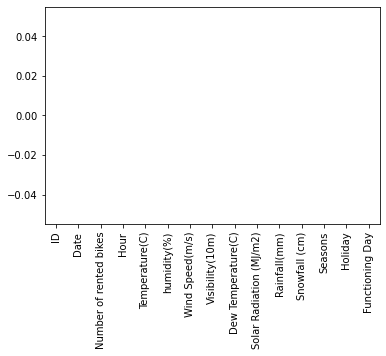

In [8]:
data.isna().sum().plot(kind="bar")
plt.show()

In [9]:
data.isna().sum()

ID                         0
Date                       0
Number of rented bikes     0
Hour                       0
Temperature(C)             0
humidity(%)                0
Wind Speed(m/s)            0
Visibility(10m)            0
Dew Temperature(C)         0
Solar Radiation (MJ/m2)    0
Rainfall(mm)               0
Snowfall (cm)              0
Seasons                    0
Holiday                    0
Functioning Day            0
dtype: int64

# Checking the type of Data

In [10]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       5760 non-null   int64  
 1   Date                     5760 non-null   object 
 2   Number of rented bikes   5760 non-null   int64  
 3   Hour                     5760 non-null   int64  
 4   Temperature(C)           5760 non-null   float64
 5   humidity(%)              5760 non-null   int64  
 6   Wind Speed(m/s)          5760 non-null   float64
 7   Visibility(10m)          5760 non-null   int64  
 8   Dew Temperature(C)       5760 non-null   float64
 9   Solar Radiation (MJ/m2)  5760 non-null   float64
 10  Rainfall(mm)             5760 non-null   float64
 11  Snowfall (cm)            5760 non-null   float64
 12  Seasons                  5760 non-null   object 
 13  Holiday                  5760 non-null   object 
 14  Functioning Day         

# Converting Date and splitting it

In [11]:
def convert_date(df):
    df["Date"]=pd.to_datetime(df["Date"],format="%d-%m-%y") 
    df["month"]=df["Date"].dt.month
    df["day"]=df["Date"].dt.day
    df["year"]=df["Date"].dt.year
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month_start'] = df['Date'].dt.is_month_start
    df['woy'] = df['Date'].dt.isocalendar().week.astype(int)
    
    return df

In [12]:
data=convert_date(data)

In [13]:
data.head()

,ID,Date,Number of rented bikes,Hour,Temperature(C),humidity(%),Wind Speed(m/s),Visibility(10m),Dew Temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,month,day,year,dayofweek,month_start,woy
0,0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48
1,1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48
2,2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48
3,3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48
4,4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48


# Statitical description of the features

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5760.0,2879.500000,1662.913107,0.0,1439.75,2879.50,4319.250,5759.00
Number of rented bikes,5760.0,703.483854,655.249491,0.0,188.00,485.50,1066.000,3556.00
Hour,5760.0,11.500000,6.922788,0.0,5.75,11.50,17.250,23.00
Temperature(C),5760.0,12.803559,11.902206,-15.1,3.20,13.70,22.225,39.40
humidity(%),5760.0,58.361806,19.840167,0.0,43.00,57.00,73.000,98.00
Wind Speed(m/s),5760.0,1.723333,1.047898,0.0,0.90,1.50,2.300,7.40
Visibility(10m),5760.0,1473.711458,585.879880,27.0,1025.75,1732.00,2000.000,2000.00
Dew Temperature(C),5760.0,4.058264,13.003582,-26.9,-5.40,5.20,14.700,27.20
Solar Radiation (MJ/m2),5760.0,0.572325,0.869943,0.0,0.00,0.01,0.940,3.52
Rainfall(mm),5760.0,0.135122,1.075320,0.0,0.00,0.00,0.000,35.00


# Exploratory Data Analysis

Text(0.5, 1.0, 'Box plot on Count Across Day of week')

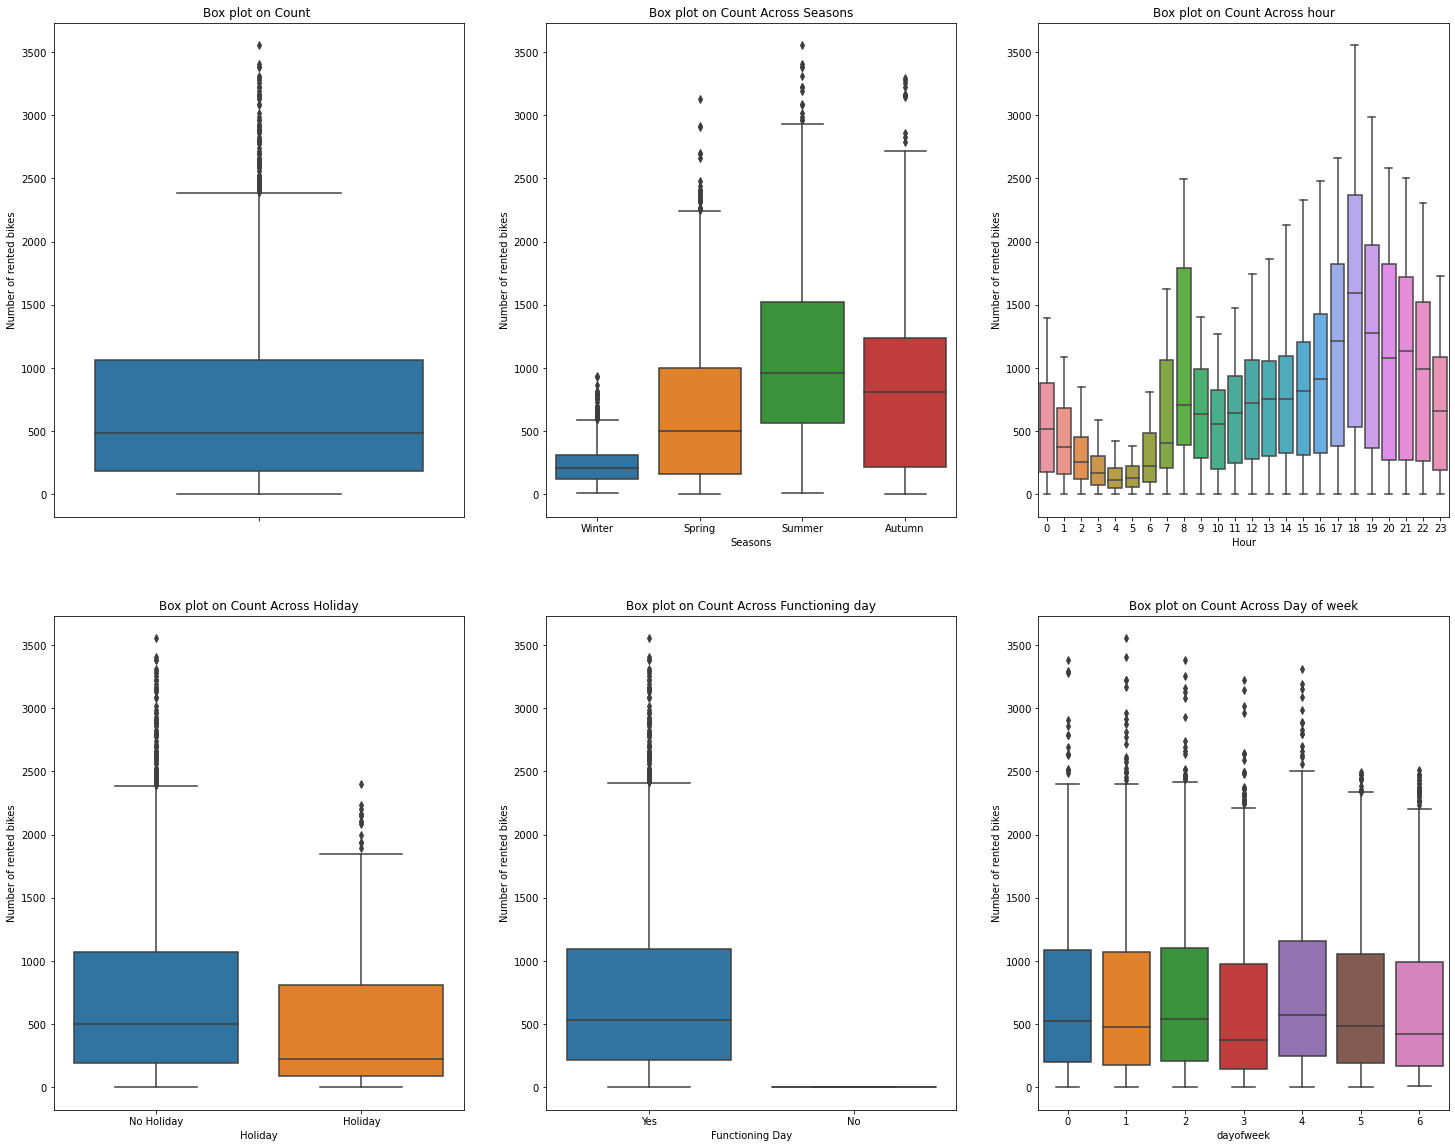

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(25, 20))
sns.boxplot(y=data["Number of rented bikes"],ax=ax[0][0])
ax[0][0].set_title("Box plot on Count ")
sns.boxplot(x="Seasons",y="Number of rented bikes",data=data,ax=ax[0][1])
ax[0][1].set_title("Box plot on Count Across Seasons")
sns.boxplot(x="Hour",y="Number of rented bikes",data=data,ax=ax[0][2])
ax[0][2].set_title("Box plot on Count Across hour")
sns.boxplot(x="Holiday",y="Number of rented bikes",data=data,ax=ax[1][0])
ax[1][0].set_title("Box plot on Count Across Holiday")
sns.boxplot(x="Functioning Day",y="Number of rented bikes",data=data,ax=ax[1][1])
ax[1][1].set_title("Box plot on Count Across Functioning day")
sns.boxplot(x="dayofweek",y="Number of rented bikes",data=data,ax=ax[1][2])
ax[1][2].set_title("Box plot on Count Across Day of week")

# Correlations between variables

<AxesSubplot:>

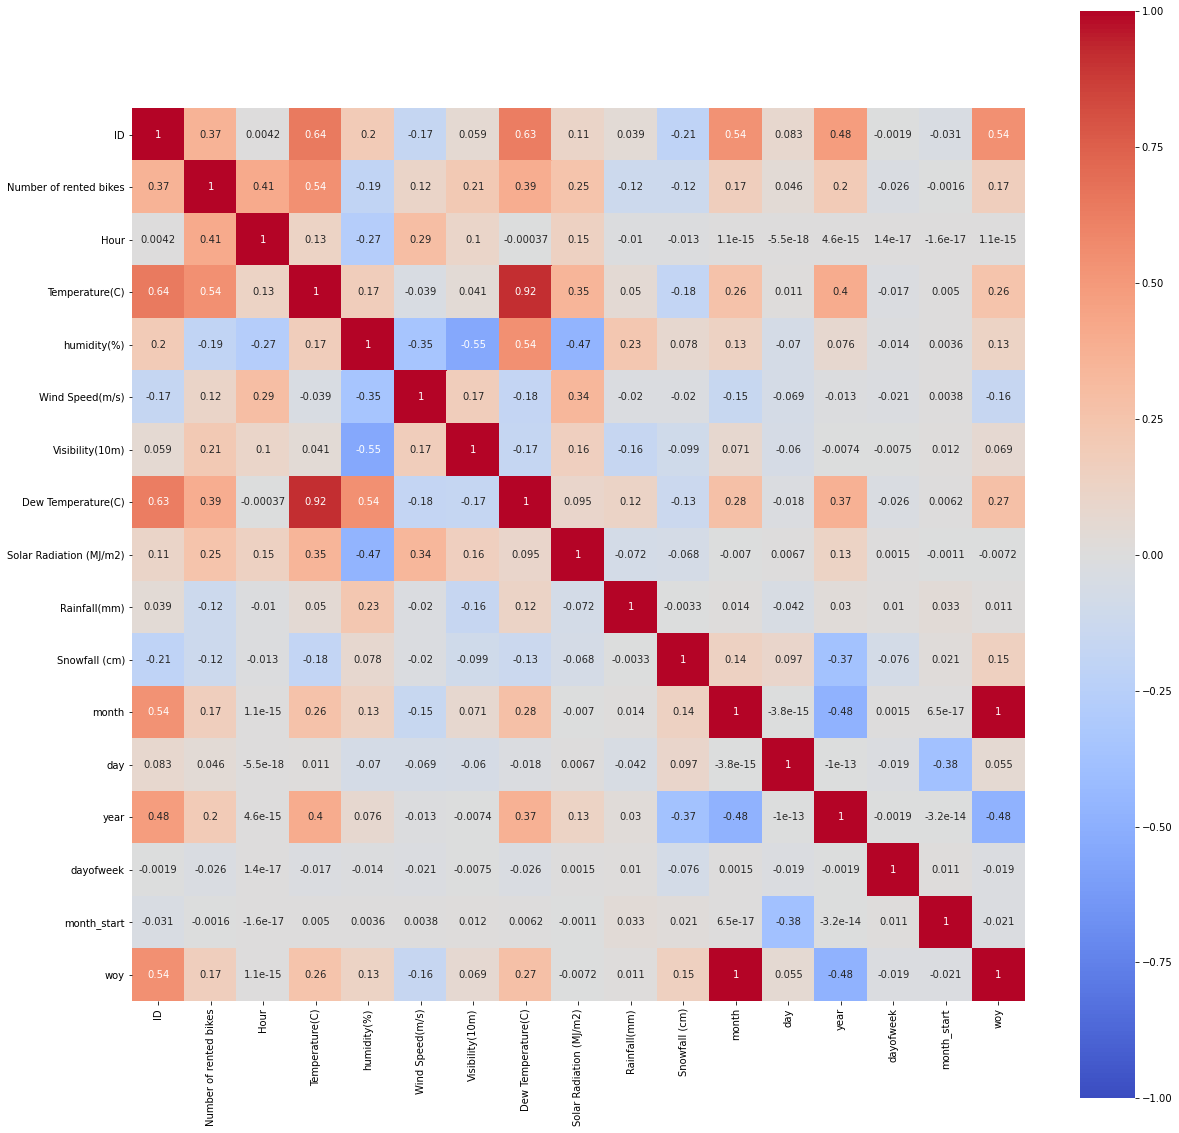

In [16]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True)

#  Sorted correlation of variables to the target

In [17]:
df1Corr=pd.DataFrame(data.corr().unstack().sort_values(ascending=False)['Number of rented bikes'],columns=['Correlation to the target'])
df1Corr.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Correlation to the target
Number of rented bikes,1.000000
Temperature(C),0.544281
Hour,0.407180
Dew Temperature(C),0.392454
ID,0.365359
Solar Radiation (MJ/m2),0.250601
Visibility(10m),0.214777
year,0.201837
woy,0.169035
month,0.167181


# Plotting variables to the target

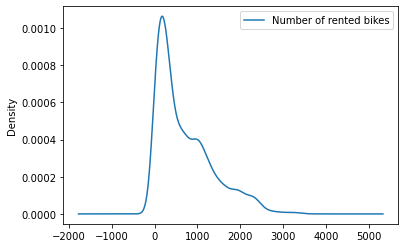

In [18]:
data.plot(x='Date',y='Number of rented bikes',kind='kde');

# Seasons with most rents¶

In [19]:
df1VizSeasons=pd.DataFrame(data.groupby('Seasons').sum()['Number of rented bikes'].sort_values(ascending=False))
df1VizSeasons.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Number of rented bikes
Seasons,
Summer,1563416
Autumn,1214630
Spring,940276
Winter,333745


# Checking the link to solar radiation

In [20]:
df1VizSolarRadiation=pd.DataFrame(data.groupby('Seasons').sum()['Solar Radiation (MJ/m2)'].sort_values(ascending=False))
df1VizSolarRadiation.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Solar Radiation (MJ/m2)
Seasons,
Summer,1167.960000
Spring,905.220000
Autumn,781.830000
Winter,441.580000


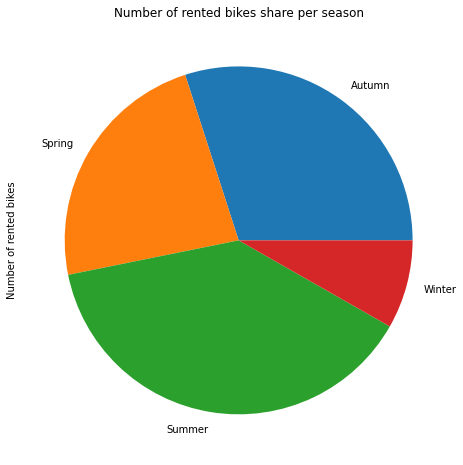

In [21]:
plt.figure(figsize=(9,8))
data.groupby('Seasons').sum()['Number of rented bikes'].plot.pie();
plt.title("Number of rented bikes share per season");

# Rented bikes vs Solar radiation

<AxesSubplot:>

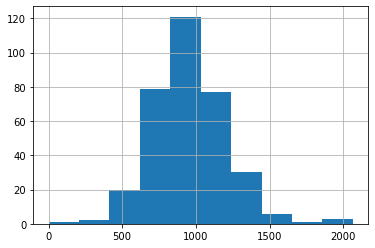

In [22]:
data.groupby('Solar Radiation (MJ/m2)').mean()['Number of rented bikes'].hist()

# Checking rents per hours

<AxesSubplot:xlabel='Hour'>

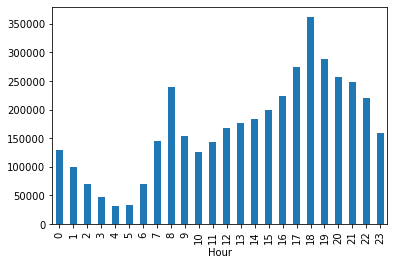

In [23]:
data.groupby('Hour').sum()['Number of rented bikes'].plot.bar()

# Rented bikes vs Days of the week

In [24]:
df1VizDays=pd.DataFrame(data.groupby('dayofweek').sum()['Number of rented bikes'].sort_values(ascending=False))
df1VizDays.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Number of rented bikes
dayofweek,
4,646191
0,612065
1,594777
2,592134
5,556266
6,538443
3,512191


Days are encoded 0 Mondays and 6 Sundays

# Temperature vs rented bikes

<AxesSubplot:xlabel='Temperature(C)'>

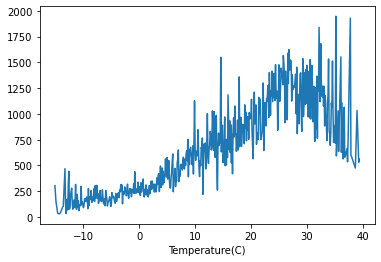

In [25]:
data.groupby('Temperature(C)').mean()['Number of rented bikes'].plot()

# Rain vs rented bikes

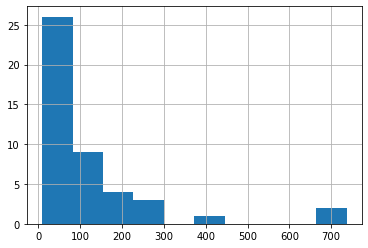

In [26]:
data.groupby('Rainfall(mm)').mean()['Number of rented bikes'].hist();

# Snowfall vs rented bikes

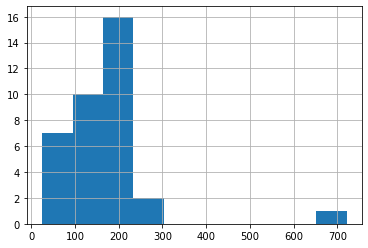

In [27]:
data.groupby('Snowfall (cm)')['Number of rented bikes'].mean().hist();

# Visualizing rents with years, months and hours

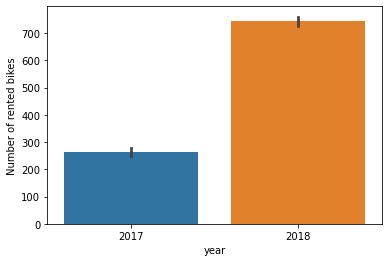

In [28]:
#plt.figure(figsize=(14,14))
sns.barplot(data=data, x='year', y=data['Number of rented bikes']);

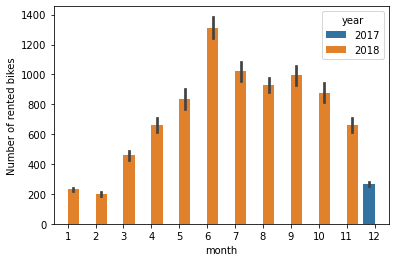

In [29]:
sns.barplot(data=data, x='month', y=data['Number of rented bikes'], hue='year');


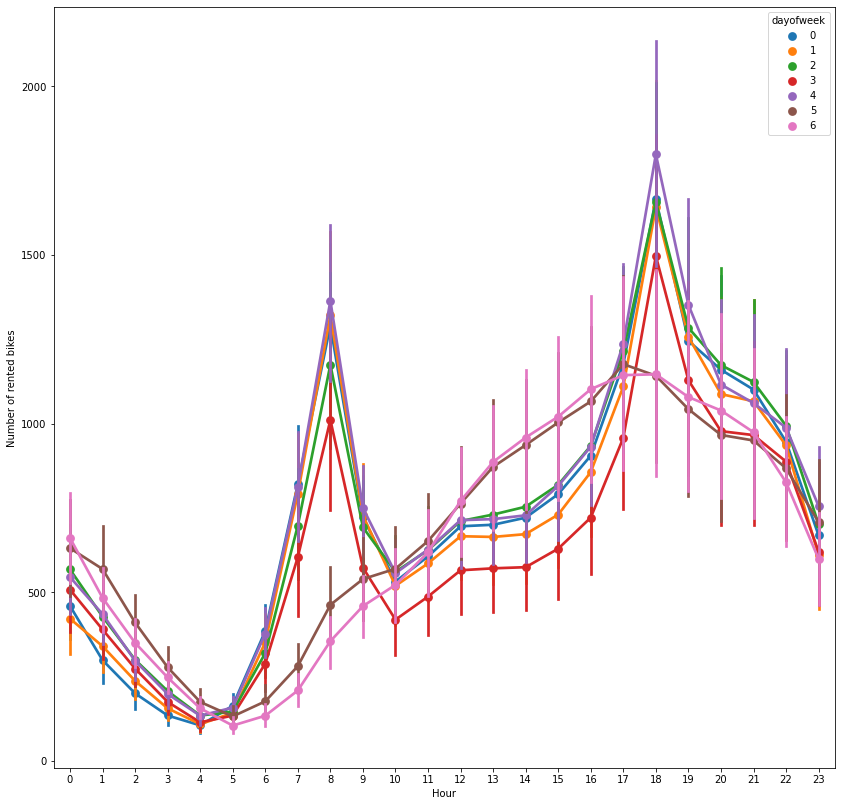

In [30]:
plt.figure(figsize=(14,14))
sns.pointplot(data=data, x='Hour', y=data['Number of rented bikes'], hue='dayofweek');

# Dropping not important Columns

In [31]:
def drop_cols(df):
    df=df.drop(['ID','Date'],axis=1)
    return df

In [32]:
data=drop_cols(data)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number of rented bikes   5760 non-null   int64  
 1   Hour                     5760 non-null   int64  
 2   Temperature(C)           5760 non-null   float64
 3   humidity(%)              5760 non-null   int64  
 4   Wind Speed(m/s)          5760 non-null   float64
 5   Visibility(10m)          5760 non-null   int64  
 6   Dew Temperature(C)       5760 non-null   float64
 7   Solar Radiation (MJ/m2)  5760 non-null   float64
 8   Rainfall(mm)             5760 non-null   float64
 9   Snowfall (cm)            5760 non-null   float64
 10  Seasons                  5760 non-null   object 
 11  Holiday                  5760 non-null   object 
 12  Functioning Day          5760 non-null   object 
 13  month                    5760 non-null   int64  
 14  day                     

# Check the outliers of Data

In [34]:
features_plot=['Number of rented bikes',  'Temperature(C)', 'humidity(%)',
       'Wind Speed(m/s)', 'Visibility(10m)', 'Dew Temperature(C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

In [35]:
data[features_plot].describe()

,Number of rented bikes,Temperature(C),humidity(%),Wind Speed(m/s),Visibility(10m),Dew Temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000
mean,703.483854,12.803559,58.361806,1.723333,1473.711458,4.058264,0.572325,0.135122,0.046302
std,655.249491,11.902206,19.840167,1.047898,585.879880,13.003582,0.869943,1.075320,0.323728
min,0.000000,-15.100000,0.000000,0.000000,27.000000,-26.900000,0.000000,0.000000,0.000000
25%,188.000000,3.200000,43.000000,0.900000,1025.750000,-5.400000,0.000000,0.000000,0.000000
50%,485.500000,13.700000,57.000000,1.500000,1732.000000,5.200000,0.010000,0.000000,0.000000
75%,1066.000000,22.225000,73.000000,2.300000,2000.000000,14.700000,0.940000,0.000000,0.000000
max,3556.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000


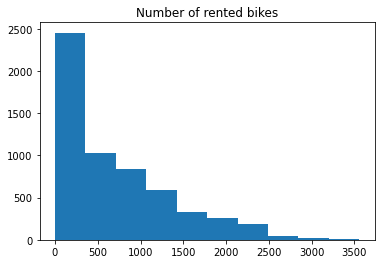

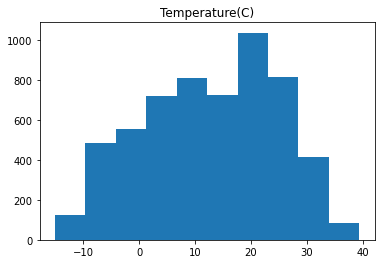

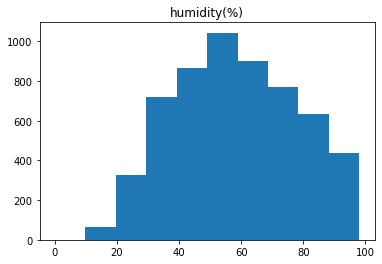

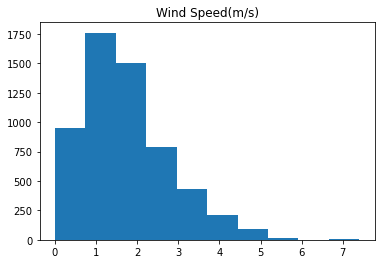

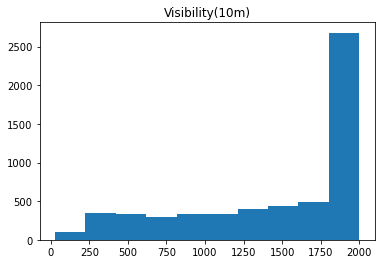

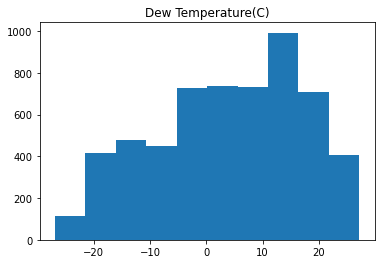

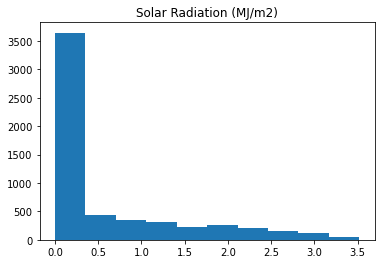

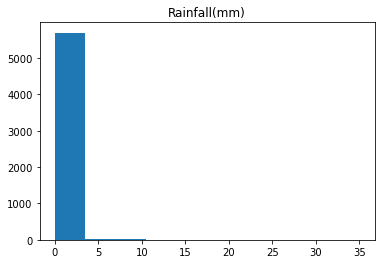

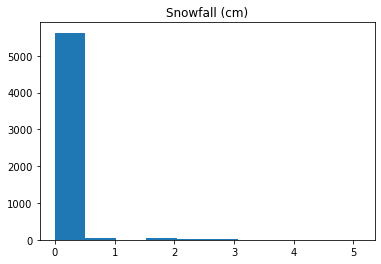

In [36]:
def my_plot(feature):
    plt.hist(data[feature])
    plt.title(feature)
    plt.show()
        
for i in features_plot:
    my_plot(i)

In [37]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins='auto')
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

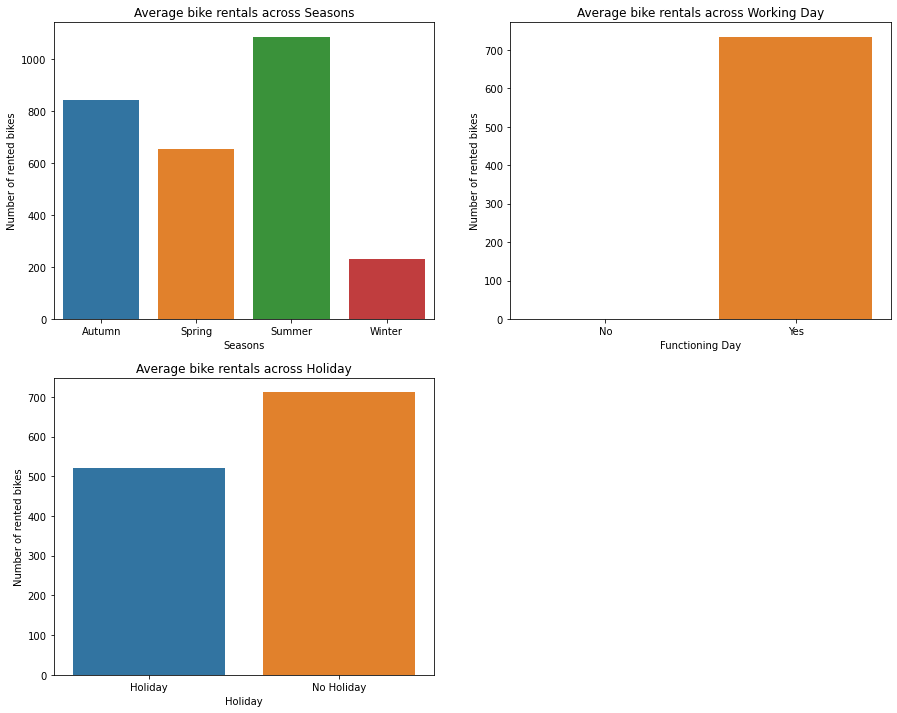

In [38]:
# Average values across each of the categorical columns 
fig = plt.figure(figsize=(15, 12))
axes = fig.add_subplot(2, 2, 1)
group_season = pd.DataFrame(data.groupby(['Seasons'])['Number of rented bikes'].mean()).reset_index()
sns.barplot(data=group_season, x='Seasons', y='Number of rented bikes', ax=axes)
axes.set(xlabel='Seasons', ylabel='Number of rented bikes', title='Average bike rentals across Seasons')

axes = fig.add_subplot(2, 2, 2)
group_workingday = pd.DataFrame(data.groupby(['Functioning Day'])['Number of rented bikes'].mean()).reset_index()
sns.barplot(data=group_workingday, x='Functioning Day', y='Number of rented bikes', ax=axes)
axes.set(xlabel='Functioning Day', ylabel='Number of rented bikes', title='Average bike rentals across Working Day')

axes = fig.add_subplot(2, 2, 3)
group_season = pd.DataFrame(data.groupby(['Holiday'])['Number of rented bikes'].mean()).reset_index()
sns.barplot(data=group_season, x='Holiday', y='Number of rented bikes', ax=axes)
axes.set(xlabel='Holiday', ylabel='Number of rented bikes', title='Average bike rentals across Holiday')
plt.show()

# Hourly count based on functioning day

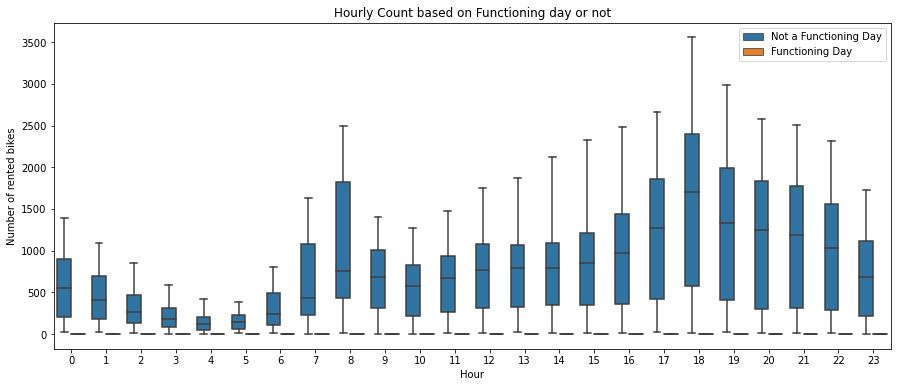

In [39]:
# seaborn boxplots across hours
f, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.boxplot(data=data, y='Number of rented bikes', x='Hour', hue='Functioning Day', ax=axes)
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Functioning Day', 'Functioning Day'])
axes.set(title='Hourly Count based on Functioning day or not')

plt.show()

# Plotting average bike count for each hour as a function of various categories.

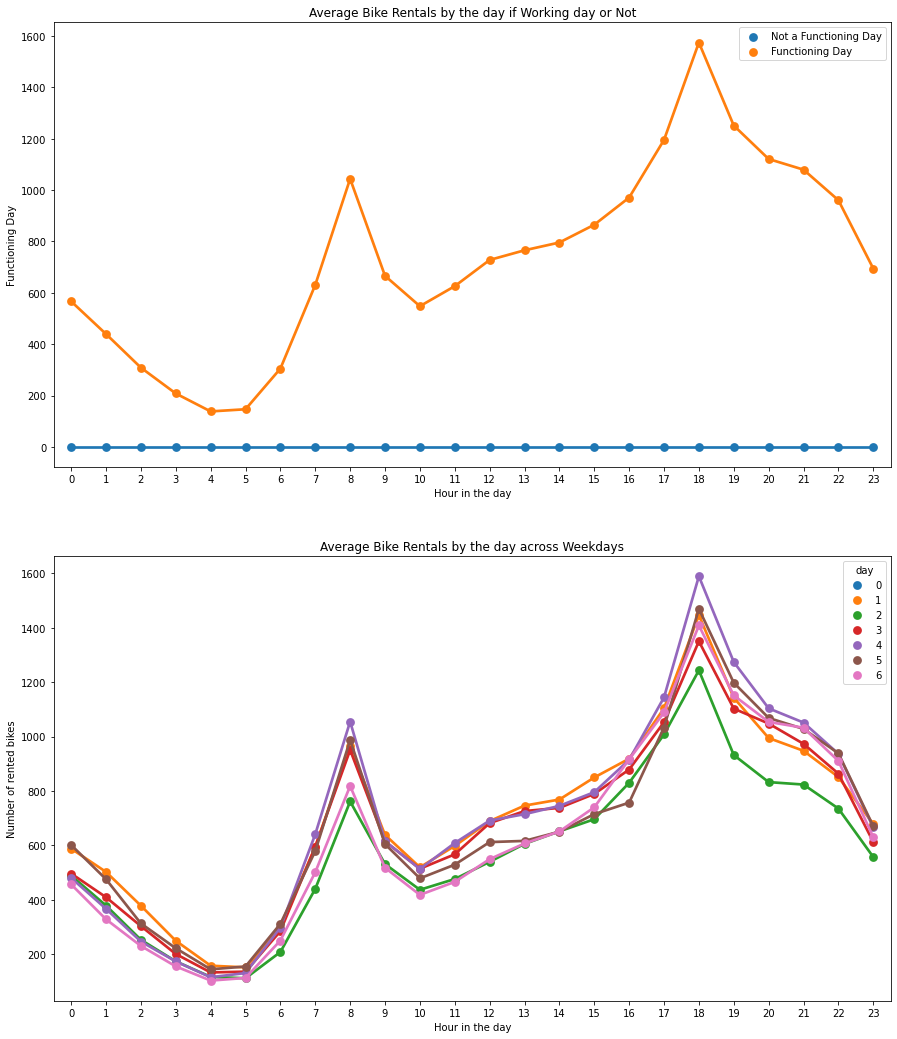

In [40]:

# Plots of average count across hour in a day for various categories

f, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 18))
group_work_hour = pd.DataFrame(data.groupby(['Functioning Day', 'Hour'])['Number of rented bikes'].mean()).reset_index()
sns.pointplot(data=group_work_hour, x='Hour', y='Number of rented bikes', hue='Functioning Day', ax=axes[0], legend=True)
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Not a Functioning Day', 'Functioning Day'])
axes[0].set(xlabel='Hour in the day', ylabel='Functioning Day', title='Average Bike Rentals by the day if Working day or Not')

hue_order= [0,1,2,3,4,5,6]
group_day_hour = pd.DataFrame(data.groupby(['day', 'Hour'])['Number of rented bikes'].mean()).reset_index()
sns.pointplot(data=group_day_hour, x='Hour', y='Number of rented bikes', hue='day', ax=axes[1], hue_order=hue_order)
axes[1].set(xlabel='Hour in the day', ylabel='Number of rented bikes', title='Average Bike Rentals by the day across Weekdays')


plt.show()

# Monthly distributions

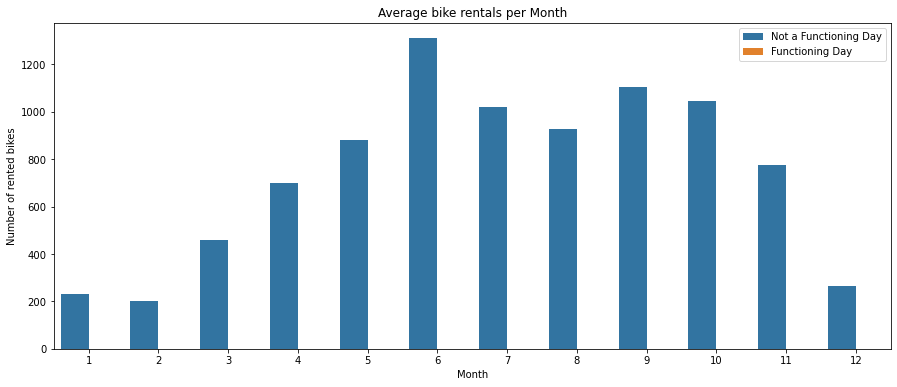

In [41]:
# Average Monthly Count Distribution plot
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
group_month = pd.DataFrame(data.groupby(['month', 'Functioning Day'])['Number of rented bikes'].mean()).reset_index()
sns.barplot(data=group_month, x='month', y='Number of rented bikes', hue='Functioning Day', ax=axes)
axes.set(xlabel='Month', ylabel='Number of rented bikes', title='Average bike rentals per Month')
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Functioning Day', 'Functioning Day'])
plt.show()

# Rented bikes vs Temperature, Humidity and Windspeed

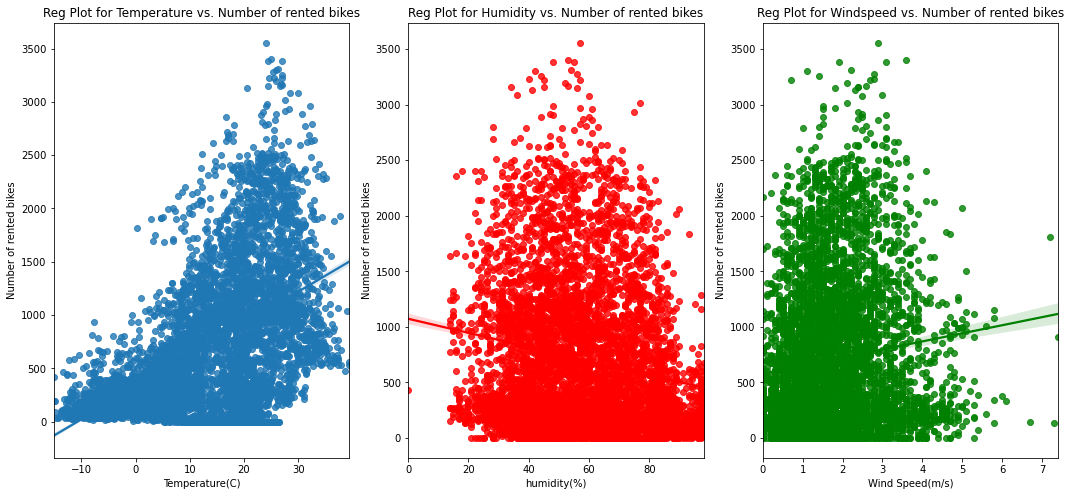

In [42]:
# Regression Plots with respect to Temperature, Humidity and Windspeed
fig = plt.figure(figsize=(18, 8))
axes = fig.add_subplot(1, 3, 1)
sns.regplot(data=data, x='Temperature(C)', y='Number of rented bikes',ax=axes)
axes.set(title='Reg Plot for Temperature vs. Number of rented bikes')
axes = fig.add_subplot(1, 3, 2)
sns.regplot(data=data, x='humidity(%)', y='Number of rented bikes',ax=axes, color='r')
axes.set(title='Reg Plot for Humidity vs. Number of rented bikes')
axes = fig.add_subplot(1, 3, 3)
sns.regplot(data=data, x='Wind Speed(m/s)', y='Number of rented bikes',ax=axes, color='g')
axes.set(title='Reg Plot for Windspeed vs. Number of rented bikes')
plt.show()

# Number of rented bikes

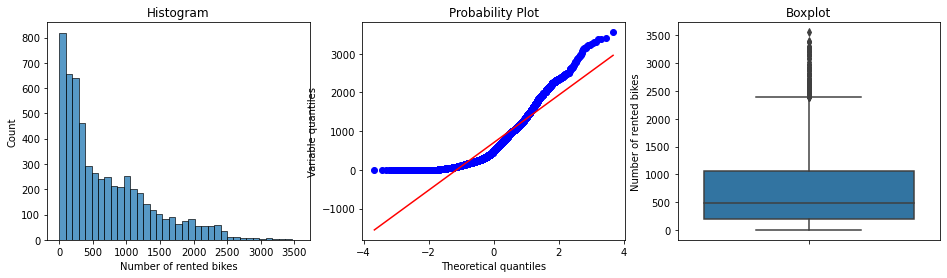

In [43]:
diagnostic_plots(data, 'Number of rented bikes')

# Temperatures

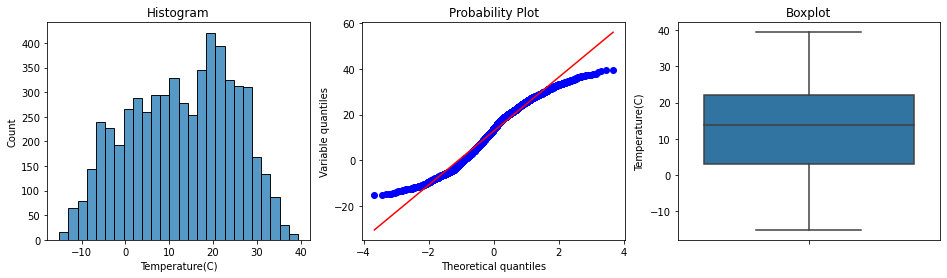

In [44]:
#showing distribution for temperature
diagnostic_plots(data, 'Temperature(C)')

# Humidity

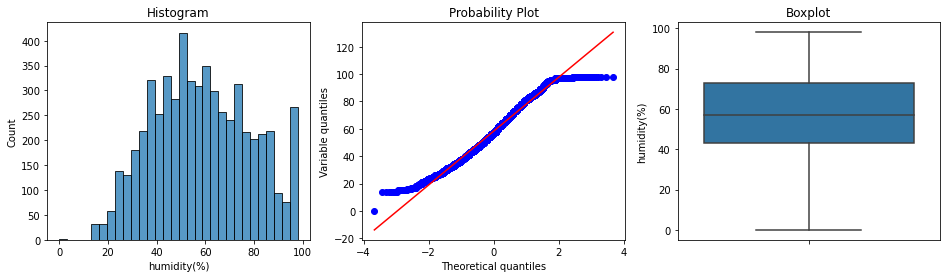

In [45]:
diagnostic_plots(data, 'humidity(%)')

# Wind Speed

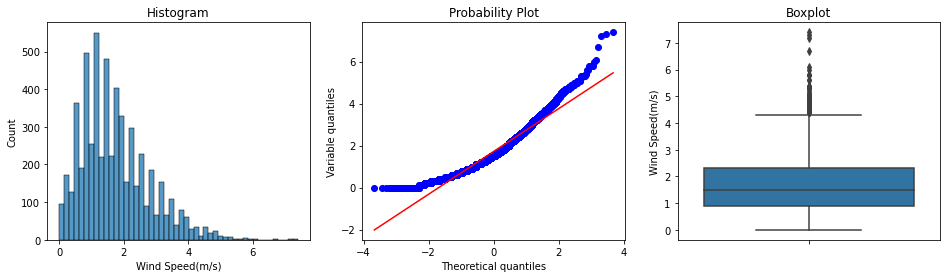

In [46]:
diagnostic_plots(data, 'Wind Speed(m/s)')

# Visibility

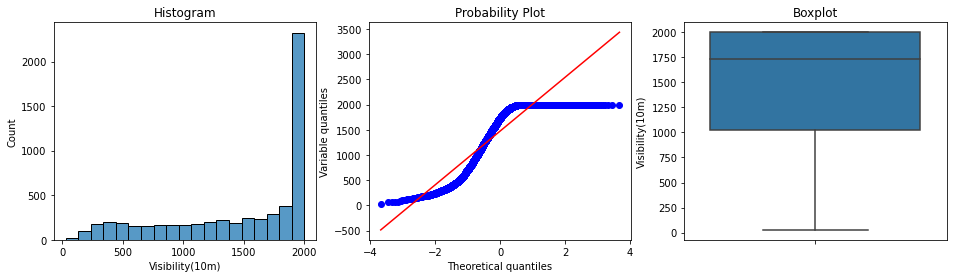

In [47]:
diagnostic_plots(data, 'Visibility(10m)')

# Dew Temperature

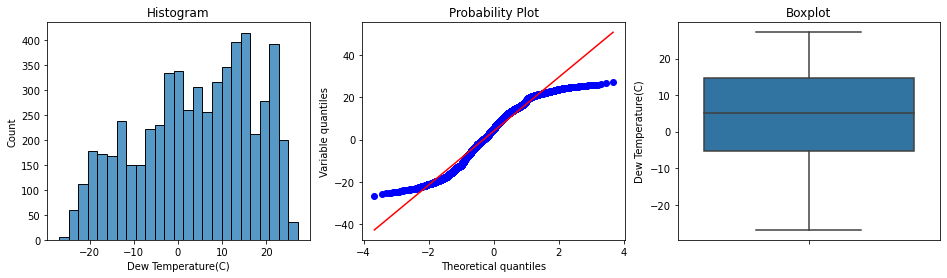

In [48]:
diagnostic_plots(data, 'Dew Temperature(C)')

# Solar Radiation

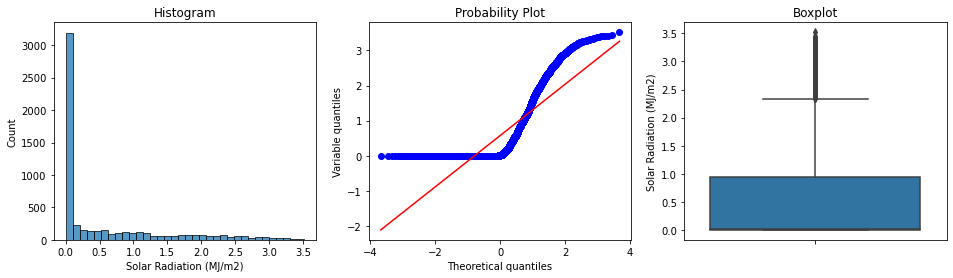

In [49]:
diagnostic_plots(data, 'Solar Radiation (MJ/m2)')

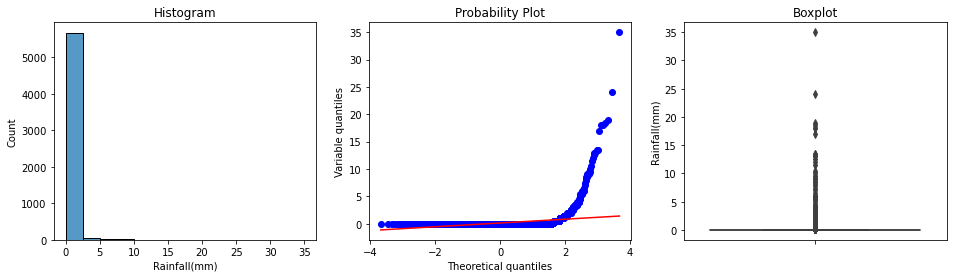

In [50]:
diagnostic_plots(data,'Rainfall(mm)')

# Snowfall

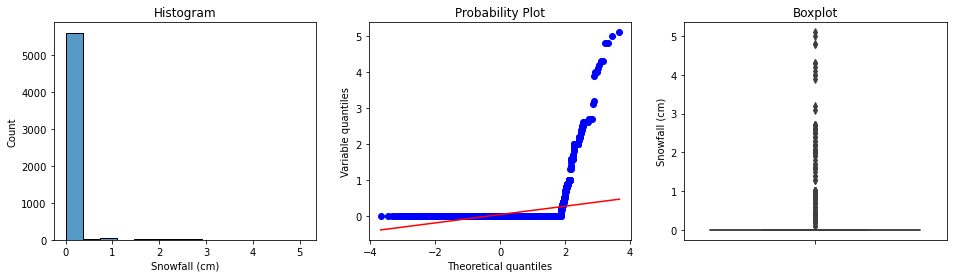

In [51]:
diagnostic_plots(data,'Snowfall (cm)')

In [52]:
data[data['Snowfall (cm)']>0].shape

(180, 19)

In [53]:
data.shape   # the data size is much larger than number of outliers in data

(5760, 19)

## Handling Outliers

In [54]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [55]:
#Finding upper and lower limt for windspeed
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(data, 'Wind Speed(m/s)', 1.5)
RM_upper_limit, RM_lower_limit

(4.3999999999999995, -1.1999999999999997)

In [56]:
# replace the outliers of windspeed by the maximum and minimum limit

data['Wind Speed(m/s)']= np.where(data['Wind Speed(m/s)'] > RM_upper_limit, RM_upper_limit,
                       np.where(data['Wind Speed(m/s)'] < RM_lower_limit, RM_lower_limit,data['Wind Speed(m/s)']))

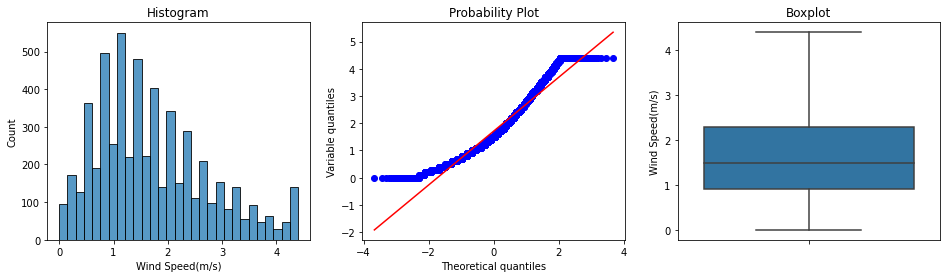

In [57]:
diagnostic_plots(data, 'Wind Speed(m/s)')

In [58]:
#Finding the maximum and minimum for solar radiation
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(data, 'Solar Radiation (MJ/m2)', 1.5)
RM_upper_limit, RM_lower_limit

(2.3499999999999996, -1.41)

In [59]:
 # replace the outliers by the maximum and minimum limit

data['Solar Radiation (MJ/m2)']= np.where(data['Solar Radiation (MJ/m2)'] > RM_upper_limit, RM_upper_limit,
                       np.where(data['Solar Radiation (MJ/m2)'] < RM_lower_limit, RM_lower_limit,data['Solar Radiation (MJ/m2)']))

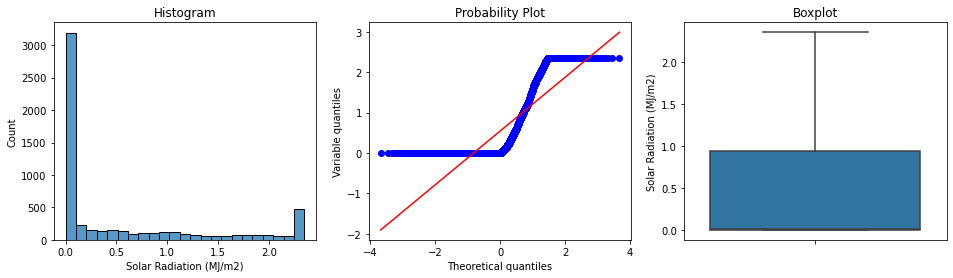

In [60]:
diagnostic_plots(data, 'Solar Radiation (MJ/m2)')

In [61]:
#Finding the maximum and minimum for solar radiation
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(data, 'Snowfall (cm)', 3)
RM_upper_limit, RM_lower_limit

(0.0, 0.0)

In [62]:
data['Snowfall (cm)']= np.where(data['Snowfall (cm)'] > RM_upper_limit, RM_upper_limit,
                       np.where(data['Snowfall (cm)'] < RM_lower_limit, RM_lower_limit,data['Snowfall (cm)']))

In [63]:
data.columns

Index(['Number of rented bikes', 'Hour', 'Temperature(C)', 'humidity(%)',
       'Wind Speed(m/s)', 'Visibility(10m)', 'Dew Temperature(C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'month', 'day', 'year', 'dayofweek',
       'month_start', 'woy'],
      dtype='object')

# applying additional function to data :peak,ideal,sticky

In [64]:
def additional(df):
    df['ideal'] = df[['Temperature(C)', 'Wind Speed(m/s)']].apply(lambda x: (0, 1)[x['Temperature(C)'] > 27 and x['Wind Speed(m/s)'] < 30], axis = 1)
    df['sticky'] = df[['humidity(%)', 'Functioning Day']].apply(lambda x: (0, 1)[x['Functioning Day'] == 1 and x['humidity(%)'] >= 60], axis = 1)
    df['solar_visibilty']=df[['Solar Radiation (MJ/m2)', 'Visibility(10m)']].apply(lambda x: (0, 1)[x['Solar Radiation (MJ/m2)'] <0.2 and x['Visibility(10m)'] > 1600], axis = 1)
    df["windchill"]=13.12+0.6215*df['Temperature(C)']-11.37*(df['Wind Speed(m/s)']*3.6)**0.16+0.3965*df['Temperature(C)'] \
    *(df['Wind Speed(m/s)']*3.6)**0.16
    df['newweather']=17.3+df['Temperature(C)']-0.11*df['humidity(%)']+0.34*df['Wind Speed(m/s)']
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/23.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/23.0)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['log_wind']=np.log1p(df['Wind Speed(m/s)'])
    df['log_hum']=np.log1p(df['humidity(%)'])
    
    return df

In [65]:
cond1 = data['Functioning Day']== 'Yes'
cond2 = data['Hour'].isin([7,8,9,17,18,19])
cond3 = data['Hour'].isin([10,11,12,13,14,15,16])
cond4 = data['Hour'].isin([0,1,2,3,4,5,6,20,21,22,23])

conditions =[~cond1,cond1&cond2,cond1&cond3,cond1&cond4]
vals = ['No','High','Medium','Low']
data['Map demand'] = np.select(conditions,vals)


In [66]:
data=additional(data)

C:\Users\NourhanElaraby\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  
C:\Users\NourhanElaraby\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  after removing the cwd from sys.path.


In [67]:
data.head()

,Number of rented bikes,Hour,Temperature(C),humidity(%),Wind Speed(m/s),Visibility(10m),Dew Temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,month,day,year,dayofweek,month_start,woy,Map demand,ideal,sticky,solar_visibilty,windchill,newweather,hour_sin,hour_cos,month_sin,month_cos,log_wind,log_hum
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48,Low,0,0,1,-8.815617,8.778,0.000000,1.000000,-2.449294e-16,1.0,1.163151,3.637586
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48,Low,0,0,1,-6.347921,7.892,0.269797,0.962917,-2.449294e-16,1.0,0.587787,3.663562
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48,Low,0,0,1,-7.485388,7.350,0.519584,0.854419,-2.449294e-16,1.0,0.693147,3.688879
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48,Low,0,0,1,-7.423287,7.006,0.730836,0.682553,-2.449294e-16,1.0,0.641854,3.713572
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48,Low,0,0,1,-9.891173,8.122,0.887885,0.460065,-2.449294e-16,1.0,1.193922,3.610918


# Showing the distribution of categorical variables

In [68]:
cat_features = data.columns[data.dtypes=='object']
cat_features=list(cat_features)

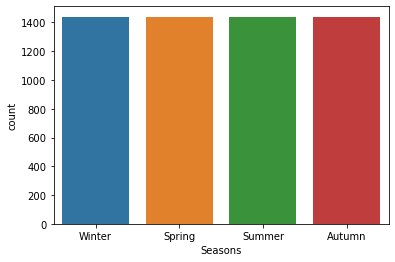

In [69]:
sns.countplot(x=cat_features[0],data=data)
plt.show()

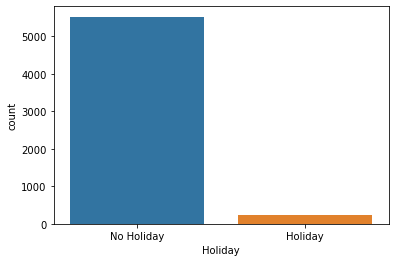

In [70]:
sns.countplot(x=cat_features[1],data=data)
plt.show()

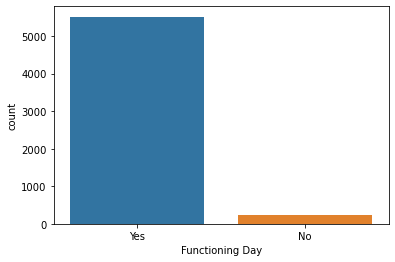

In [71]:
sns.countplot(x=cat_features[2],data=data)
plt.show()

In [72]:
def count_category(name):
    print(name)
    print(data[name].value_counts())
    print("-------------------------------------------------")
for i in cat_features:
    count_category(i)

Seasons
Summer    1440
Autumn    1440
Winter    1440
Spring    1440
Name: Seasons, dtype: int64
-------------------------------------------------
Holiday
No Holiday    5520
Holiday        240
Name: Holiday, dtype: int64
-------------------------------------------------
Functioning Day
Yes    5513
No      247
Name: Functioning Day, dtype: int64
-------------------------------------------------
Map demand
Low       2523
Medium    1610
High      1380
No         247
Name: Map demand, dtype: int64
-------------------------------------------------


# EDA

In [73]:
count_bikes_by_hour = data.groupby("Hour")["Number of rented bikes"].sum()
print(count_bikes_by_hour)

Hour
0     129757
1     100629
2      70645
3      47608
4      31609
5      33539
6      69795
7     145036
8     240061
9     153182
10    125993
11    143934
12    167402
13    176055
14    183030
15    198943
16    223279
17    274895
18    362133
19    287781
20    257818
21    248275
22    220926
23    159742
Name: Number of rented bikes, dtype: int64


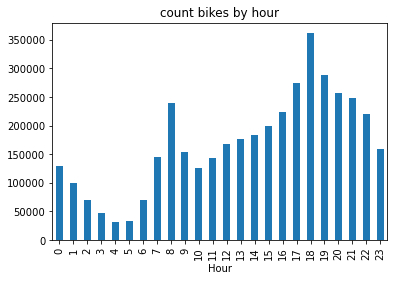

In [74]:
count_bikes_by_hour.plot(kind="bar",
title="count bikes by hour")
plt.savefig('count bikes by hr')
plt.show()

In [75]:
count_bikes_by_Holiday = data.groupby("Holiday")["Number of rented bikes"].sum()
print(count_bikes_by_Holiday)

Holiday
Holiday        124849
No Holiday    3927218
Name: Number of rented bikes, dtype: int64


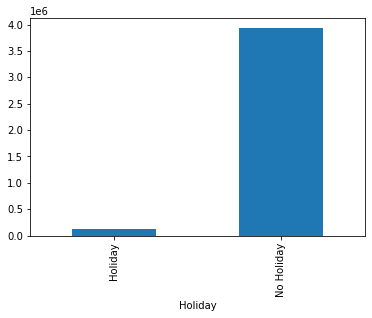

In [76]:
data.groupby("Holiday")["Number of rented bikes"].sum().plot(kind="bar")
plt.savefig("count bikes by holiday")
plt.show()

In [77]:
count_bikes_by_funcday = data.groupby("Functioning Day")["Number of rented bikes"].sum()
print(count_bikes_by_funcday)

Functioning Day
No           0
Yes    4052067
Name: Number of rented bikes, dtype: int64


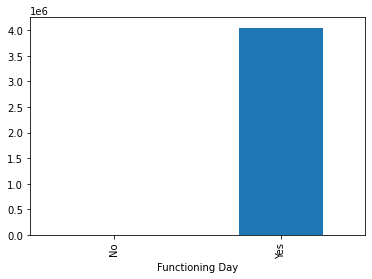

In [78]:
data.groupby("Functioning Day")["Number of rented bikes"].sum().plot(kind="bar")
plt.savefig("count_bikes_by_funcday")
plt.show()

In [79]:
count_bikes_by_Season = data.groupby("Seasons")["Number of rented bikes"].sum()
print(count_bikes_by_Season)

Seasons
Autumn    1214630
Spring     940276
Summer    1563416
Winter     333745
Name: Number of rented bikes, dtype: int64


<AxesSubplot:xlabel='Seasons'>

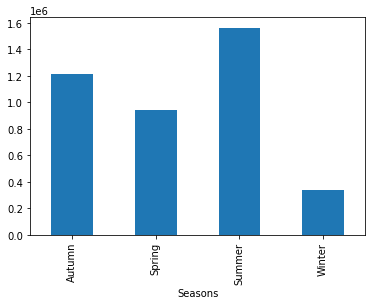

In [80]:
count_bikes_by_Season.plot(kind="bar")

## conclusion

There is a peak for renting bikes at 8 am and 6 pm which is most probably the time a person is going to or leaving his work

This is the order of season for number of rented bikes(descending order) ,

1)Autumn

2)Summer

3)Spring,

4)Winter

Most people rent bikes on Functioning days and days which aren't holidays

# Rolling Mean with window of 3

In [81]:
def rolling_mean(df,cols,window=3):
    for col in cols:
        new_col = col+'_rolled'
        df[new_col] = df[col].rolling(window=window).mean()
    return df


In [82]:
data =  rolling_mean(data,['Temperature(C)','Wind Speed(m/s)','Rainfall(mm)',
                           'Snowfall (cm)','humidity(%)','Visibility(10m)'])


In [83]:
def shifting(df,cols):
    for col in cols:
        new_col = col+'_shifted'
        df[new_col] = df[col].shift(periods=-1)
    return df
data =  shifting(data,['Temperature(C)','Wind Speed(m/s)','Rainfall(mm)', 'Snowfall (cm)','humidity(%)','Visibility(10m)'])
def shifting_1(df,cols):
    for col in cols:
        new_col = col+'_shifted1'
        df[new_col] = df[col].shift(periods=-2)
    return df
data =  shifting_1(data,['Temperature(C)','Wind Speed(m/s)','Rainfall(mm)', 'Snowfall (cm)'])

def shifting_2(df,cols):
    for col in cols:
        new_col = col+'_shifted2'
        df[new_col] = df[col].shift(periods=-3)
    return df
data =  shifting_2(data,['Temperature(C)','Wind Speed(m/s)','Rainfall(mm)', 'Snowfall (cm)'])

In [84]:
data=data.fillna(data.mean())

In [85]:
data.head()

,Number of rented bikes,Hour,Temperature(C),humidity(%),Wind Speed(m/s),Visibility(10m),Dew Temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,month,day,year,dayofweek,month_start,woy,Map demand,ideal,sticky,solar_visibilty,windchill,newweather,hour_sin,hour_cos,month_sin,month_cos,log_wind,log_hum,Temperature(C)_rolled,Wind Speed(m/s)_rolled,Rainfall(mm)_rolled,Snowfall (cm)_rolled,humidity(%)_rolled,Visibility(10m)_rolled,Temperature(C)_shifted,Wind Speed(m/s)_shifted,Rainfall(mm)_shifted,Snowfall (cm)_shifted,humidity(%)_shifted,Visibility(10m)_shifted,Temperature(C)_shifted1,Wind Speed(m/s)_shifted1,Rainfall(mm)_shifted1,Snowfall (cm)_shifted1,Temperature(C)_shifted2,Wind Speed(m/s)_shifted2,Rainfall(mm)_shifted2,Snowfall (cm)_shifted2
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48,Low,0,0,1,-8.815617,8.778,0.000000,1.000000,-2.449294e-16,1.0,1.163151,3.637586,12.807335,1.712209,0.135168,0.0,58.368299,1473.562001,-5.5,0.8,0.0,0.0,38.0,2000.0,-6.0,1.0,0.0,0.0,-6.2,0.9,0.0,0.0
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48,Low,0,0,1,-6.347921,7.892,0.269797,0.962917,-2.449294e-16,1.0,0.587787,3.663562,12.807335,1.712209,0.135168,0.0,58.368299,1473.562001,-6.0,1.0,0.0,0.0,39.0,2000.0,-6.2,0.9,0.0,0.0,-6.0,2.3,0.0,0.0
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48,Low,0,0,1,-7.485388,7.350,0.519584,0.854419,-2.449294e-16,1.0,0.693147,3.688879,-5.566667,1.333333,0.000000,0.0,38.000000,2000.000000,-6.2,0.9,0.0,0.0,40.0,2000.0,-6.0,2.3,0.0,0.0,-6.4,1.5,0.0,0.0
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48,Low,0,0,1,-7.423287,7.006,0.730836,0.682553,-2.449294e-16,1.0,0.641854,3.713572,-5.900000,0.900000,0.000000,0.0,39.000000,2000.000000,-6.0,2.3,0.0,0.0,36.0,2000.0,-6.4,1.5,0.0,0.0,-6.6,1.3,0.0,0.0
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,1,2017,4,True,48,Low,0,0,1,-9.891173,8.122,0.887885,0.460065,-2.449294e-16,1.0,1.193922,3.610918,-6.066667,1.400000,0.000000,0.0,38.333333,2000.000000,-6.4,1.5,0.0,0.0,37.0,2000.0,-6.6,1.3,0.0,0.0,-7.4,0.9,0.0,0.0


# Converting Categorical Varibales

In [86]:
def conv_cat_features(df):
    df['Holiday'].replace({"No Holiday":1, "Holiday":0}, inplace=True)
    df['Functioning Day'].replace({"Yes":1, "No":0}, inplace=True)
    data_cat_transformed = pd.get_dummies(df, drop_first=True)
    return data_cat_transformed

In [87]:
data_cat_transformed=conv_cat_features(data)
# Print the number of features after one-hot encoding
print("{} total features after one-hot encoding.".format(len(data_cat_transformed.columns)))
print(data_cat_transformed.columns)#

55 total features after one-hot encoding.
Index(['Number of rented bikes', 'Hour', 'Temperature(C)', 'humidity(%)',
       'Wind Speed(m/s)', 'Visibility(10m)', 'Dew Temperature(C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Holiday',
       'Functioning Day', 'month', 'day', 'year', 'dayofweek', 'month_start',
       'woy', 'ideal', 'sticky', 'solar_visibilty', 'windchill', 'newweather',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'log_wind', 'log_hum',
       'Temperature(C)_rolled', 'Wind Speed(m/s)_rolled',
       'Rainfall(mm)_rolled', 'Snowfall (cm)_rolled', 'humidity(%)_rolled',
       'Visibility(10m)_rolled', 'Temperature(C)_shifted',
       'Wind Speed(m/s)_shifted', 'Rainfall(mm)_shifted',
       'Snowfall (cm)_shifted', 'humidity(%)_shifted',
       'Visibility(10m)_shifted', 'Temperature(C)_shifted1',
       'Wind Speed(m/s)_shifted1', 'Rainfall(mm)_shifted1',
       'Snowfall (cm)_shifted1', 'Temperature(C)_shifted2',
       'Wind Sp

# Splitting the data into features and Target Label

In [88]:
# Split the data into features and target label
X = data_cat_transformed.drop('Number of rented bikes', axis=1)
y = data_cat_transformed['Number of rented bikes']
def custom_train_valid_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    valid = data[data['day'] > cutoff_day]
    return train,valid

train,valid =  custom_train_valid_split(data, cutoff_day=15)
train_idx = train.index
valid_idx = valid.index
myCViterator = []
myCViterator.append( (train_idx, valid_idx) )

# Create Training Model

## Define Loss Function

In [89]:
def RMSLE(y_train,y_pred):
    return np.sqrt(mean_squared_log_error(y_train, y_pred))

In [90]:
def train_predict(regressor): 
    '''
    inputs:
       - regressor: the learning algorithm to be trained and predicted on
    '''
    
    results = {}
    
    # Fit the classifier to the training data and Calculate the time
    start_train = time()
    regressor = regressor.fit(X, y)
    end_train = time()
    results['train_time'] = round((end_train-start_train), 2)

    # Predict the training/testing labels and Calculate the time
    start_test = time()
    y_pred_train = regressor.predict(X)
    y_pred_test = regressor.predict(test_cat_transformed)
    end_test = time()   
    results['pred_time'] = round((end_test-start_test), 2)
    results['RMSLE_train'] =round(RMSLE(y, y_pred_train),4) 
    results['Rsquared_train'] = r2_score(y, y_pred_train)
    results['MSE_train'] = mean_squared_error(y, y_pred_train)
    return results,y_pred_test

# Test Data

In [91]:
test_df=pd.read_csv('test.csv')
test_df_copy=test_df.copy()

In [92]:
test_df.describe()

,ID,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,7259.500000,11.500000,13.035300,57.966000,1.727933,1366.005333,4.103667,0.562940,0.174733,0.130300
std,866.169729,6.923341,12.026752,21.330288,1.013826,643.374688,13.170840,0.866555,1.223086,0.592634
min,5760.000000,0.000000,-17.800000,0.000000,0.000000,33.000000,-30.600000,0.000000,0.000000,0.000000
25%,6509.750000,5.750000,3.900000,40.000000,0.900000,779.000000,-3.900000,0.000000,0.000000,0.000000
50%,7259.500000,11.500000,13.950000,58.000000,1.500000,1591.500000,4.900000,0.010000,0.000000,0.000000
75%,8009.250000,17.250000,22.900000,76.000000,2.400000,2000.000000,15.600000,0.910000,0.000000,0.000000
max,8759.000000,23.000000,38.000000,98.000000,6.900000,2000.000000,26.800000,3.520000,29.500000,8.800000


In [93]:
test_df.head()

,ID,Date,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,5760,21/12/2017,0,-1.3,90,2.0,259,-2.7,0.0,0.0,2.2,Winter,No Holiday,Yes
1,5761,21/12/2017,1,-1.8,90,1.6,263,-3.2,0.0,0.0,2.2,Winter,No Holiday,Yes
2,5762,21/12/2017,2,-2.2,88,1.4,348,-3.9,0.0,0.0,2.2,Winter,No Holiday,Yes
3,5763,21/12/2017,3,-2.9,89,1.3,288,-4.4,0.0,0.0,2.2,Winter,No Holiday,Yes
4,5764,21/12/2017,4,-3.6,91,1.2,241,-4.8,0.0,0.0,2.2,Winter,No Holiday,Yes


In [94]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         3000 non-null   int64  
 1   Date                       3000 non-null   object 
 2   Hour                       3000 non-null   int64  
 3   Temperature(�C)            3000 non-null   float64
 4   Humidity(%)                3000 non-null   int64  
 5   Wind speed (m/s)           3000 non-null   float64
 6   Visibility (10m)           3000 non-null   int64  
 7   Dew point temperature(�C)  3000 non-null   float64
 8   Solar Radiation (MJ/m2)    3000 non-null   float64
 9   Rainfall(mm)               3000 non-null   float64
 10  Snowfall (cm)              3000 non-null   float64
 11  Seasons                    3000 non-null   object 
 12  Holiday                    3000 non-null   object 
 13  Functioning Day            3000 non-null   objec

In [95]:
test_df.columns

Index(['ID', 'Date', 'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [96]:
test_df=test_df.rename(columns={col_names[4]: "Temperature(C)", col_names[5]: "humidity(%)",col_names[6]:"Wind Speed(m/s)",\
              col_names[7]:"Visibility(10m)",col_names[8]:"Dew Temperature(C)",col_names[2]:"Number of rented bikes"})

In [99]:
def convert_date(df):
    df["Date"]=pd.to_datetime(df["Date"],format="%d/%m/%Y") 
    df["month"]=df["Date"].dt.month
    df["day"]=df["Date"].dt.day
    df["year"]=df["Date"].dt.year
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month_start'] = df['Date'].dt.is_month_start
    df['woy'] = df['Date'].dt.isocalendar().week.astype(int)
    
    return df

In [100]:
#test_df.head()

In [101]:
test_df=convert_date(test_df)

In [102]:
cond1 = test_df['Functioning Day']=='Yes'
cond2 = test_df['Hour'].isin([7,8,9,17,18,19])
cond3 = test_df['Hour'].isin([10,11,12,13,14,15,16])
cond4 = test_df['Hour'].isin([0,1,2,3,4,5,6,20,21,22,23])
conditions =[~cond1,cond1&cond2,cond1&cond3,cond1&cond4]
vals = ['No','High','Medium','Low']
test_df['Map demand'] = np.select(conditions,vals)

In [103]:
test_df=test_df.drop(['ID','Date'],axis=1)

In [104]:
test_df=additional(test_df)

C:\Users\NourhanElaraby\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  
C:\Users\NourhanElaraby\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  after removing the cwd from sys.path.


In [105]:
test_df =  rolling_mean(test_df,['Temperature(C)','Wind Speed(m/s)','Rainfall(mm)', 'Snowfall (cm)','humidity(%)','Visibility(10m)'])
test_df =  shifting(test_df,['Temperature(C)','Wind Speed(m/s)','Rainfall(mm)', 'Snowfall (cm)','humidity(%)','Visibility(10m)'])
test_df =  shifting_1(test_df,['Temperature(C)','Wind Speed(m/s)','Rainfall(mm)', 'Snowfall (cm)'])
test_df =  shifting_2(test_df,['Temperature(C)','Wind Speed(m/s)','Rainfall(mm)', 'Snowfall (cm)'])
test_df=test_df.fillna(test_df.mean())

In [106]:
test_cat_transformed=conv_cat_features(test_df)

> After Running HyperParameter Tuning jobs on xgboost model and catboost model the optimum parameters reached were:
> - XGBoost: {}
> - CatBoost: {}

In [107]:
X_train=X.copy()
X_test=test_cat_transformed.copy()

In [108]:
print(X_train.shape)
print(X_test.shape)

(5760, 54)
(3000, 54)


In [109]:
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()

In [110]:
X_train_xgb=X_train.drop(['hour_sin', 'hour_cos','month_sin', 'month_cos','woy','windchill', 
                      'newweather','Temperature(C)_rolled','Dew Temperature(C)','Visibility(10m)_rolled',
                      'humidity(%)','Visibility(10m)_shifted','Wind Speed(m/s)_rolled','Seasons_Spring', 
                      'Seasons_Summer','Seasons_Winter','log_hum'],axis=1)
X_test_xgb=X_test.drop(['hour_sin', 'hour_cos','month_sin', 'month_cos','woy','windchill', 
                    'newweather','Temperature(C)_rolled','Dew Temperature(C)','Visibility(10m)_rolled',
                    'humidity(%)','Visibility(10m)_shifted','Wind Speed(m/s)_rolled','Seasons_Spring',
                    'Seasons_Summer','Seasons_Winter','log_hum'],axis=1)

In [111]:
xgb_v = XGBRegressor(
   objective='count:poisson',random_state=42)



xgb= XGBRegressor(
    objective='count:poisson',random_state=42,
   subsample= 0.83, n_estimators= 3000, 
   min_child_weight= 16, max_depth= 5, 
   learning_rate= 0.055, gamma= 1, colsample_bytree= 0.5)

catboost_v=CatBoostRegressor(objective='Poisson',iterations=4000,l2_leaf_reg=1,learning_rate=0.054  , silent = True)
catboosttrial=CatBoostRegressor(objective='Poisson',iterations=4000,l2_leaf_reg=1,learning_rate=0.054,silent=True)                              
xgb_models={
    "XGB_vanella":xgb_v,
    "XGB_mod" : xgb }
cat_models ={
    "Catbbost_mod" :catboosttrial,
    "Catboost_Vanilla" :catboost_v}

In [112]:
columns = ['Regressor', 'RMSLE']

df_scores_cat = pd.DataFrame(columns=columns)
for name, model in cat_models.items():
    model.fit(X_train_cat, y)
    Y_predicted = model.predict(X_train_cat)
    rmsle = np.sqrt(mean_squared_log_error(y, Y_predicted))
    df_row = pd.DataFrame([[name, rmsle]], columns=columns)
    df_scores_cat = df_scores_cat.append(df_row, ignore_index=True)

In [113]:
columns = ['Regressor', 'RMSLE']

df_scores_xgb = pd.DataFrame(columns=columns)
for name, model in xgb_models.items():
    model.fit(X_train_xgb, y)
    Y_predicted = model.predict(X_train_xgb)
    rmsle = np.sqrt(mean_squared_log_error(y, Y_predicted))
    df_row = pd.DataFrame([[name, rmsle]], columns=columns)
    df_scores_xgb = df_scores_xgb.append(df_row, ignore_index=True)

In [114]:
df_scores_cat.sort_values(by=['RMSLE'])

,Regressor,RMSLE
0,Catbbost_mod,0.071627
1,Catboost_Vanilla,0.071627


In [115]:
df_scores_xgb.sort_values(by=['RMSLE'])

,Regressor,RMSLE
1,XGB_mod,0.069754
0,XGB_vanella,0.154825


# Plot Feature importance from Xgboostregressor without any hyperparameter tuning

<Figure size 2160x2160 with 0 Axes>

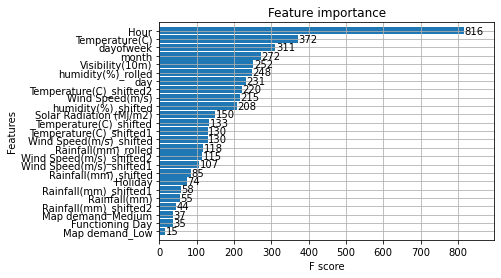

In [118]:
from xgboost import plot_importance, plot_tree
fig = plt.figure(figsize=(30,30))
fig = plot_importance(xgb_v, height=0.9,max_num_features = 25)
plt.show()

# Plot Feature importance from Xgboostregressor with best parameters after hyperparameter tuning

<Figure size 2160x2160 with 0 Axes>

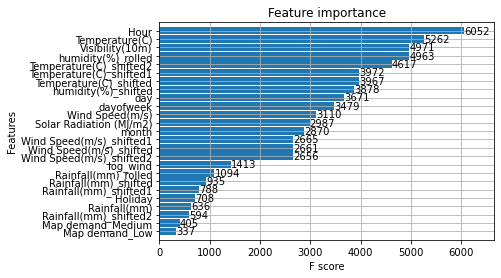

In [120]:
fig = plt.figure(figsize=(30,30))
fig = plot_importance(xgb, height=0.9,max_num_features = 25)
plt.show()

# Getting the results on Test Data

In [121]:
y_cat_pred=catboosttrial.predict(X_test_cat)

In [122]:
y_xgb_pred=xgb.predict(X_test_xgb)

In [123]:
# #getting the output from train predicgt func
test_df_copy['yxgb']=y_xgb_pred.astype('int')
test_df_copy['ycat']=y_cat_pred.astype('int')

# Blending the Results

In [124]:
yavg = 0.64*test_df_copy['yxgb'] + 0.36*test_df_copy['ycat']
test_df_copy['y'] = yavg.astype('int')

In [125]:
test_df_copy[test_df_copy["Functioning Day"]=='No']

,ID,Date,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,yxgb,ycat,y
2424,8184,28/09/2018,0,17.1,52,1.4,2000,7.1,0.00,0.0,0.0,Autumn,No Holiday,No,0,0,0
2425,8185,28/09/2018,1,16.5,53,1.5,2000,6.8,0.00,0.0,0.0,Autumn,No Holiday,No,0,0,0
2426,8186,28/09/2018,2,16.0,56,1.5,2000,7.2,0.00,0.0,0.0,Autumn,No Holiday,No,0,0,0
2427,8187,28/09/2018,3,15.3,59,1.6,2000,7.3,0.00,0.0,0.0,Autumn,No Holiday,No,0,0,0
2428,8188,28/09/2018,4,14.7,62,1.5,2000,7.4,0.00,0.0,0.0,Autumn,No Holiday,No,0,0,0
2429,8189,28/09/2018,5,14.5,60,1.4,2000,6.8,0.00,0.0,0.0,Autumn,No Holiday,No,0,0,0
2430,8190,28/09/2018,6,14.4,61,1.2,2000,6.9,0.00,0.0,0.0,Autumn,No Holiday,No,0,0,0
2431,8191,28/09/2018,7,14.5,62,1.5,2000,7.2,0.03,0.0,0.0,Autumn,No Holiday,No,0,0,0
2432,8192,28/09/2018,8,15.2,58,1.7,2000,6.9,0.29,0.0,0.0,Autumn,No Holiday,No,0,0,0
2433,8193,28/09/2018,9,16.5,50,1.2,2000,6.0,0.66,0.0,0.0,Autumn,No Holiday,No,0,0,0


In [126]:
test_df_copy[['ID','y']].to_csv("submission.csv",index=False)